In [1]:
%matplotlib inline

from discrete_shocklets import shocklets, kernel_functions
import matplotlib.pyplot as plt
import numpy as np

# Discrete Shocklet (cusplet?) Transform

This provides a few examples of the discrete shocklet (affectionately referred to as a cusplet by some...) transform---or DST---in practice. We will show how the group action of $R_4$ on the kernel function affects the output of the transform and demonstrate the automated extraction of anomalous dynamics using the post-processing algorithms. You can find theoretical information about this collection of algorithms---and some applications---in the original paper: http://compstorylab.org/share/papers/dewhurst2019a/. 

First we will show what a cusplet transform actually looks like. We will use a pretty boring time series for this: just a random walk, $x_n - x_{n-1} = u_n$, where $u_n \sim \mathcal{U}(\{-1, 1\})$.

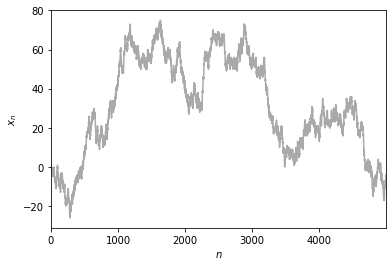

In [2]:
np.random.seed(50)
noise = np.random.choice([-1, 1], size=5000, replace=True)
x = np.cumsum(noise)
plt.plot(x, 'darkgray')
plt.xlabel('$n$')
plt.ylabel('$x_n$')
plt.xlim(0, 5000 - 1);

At its core, the DST is just simple cross-correlation of a kernel function $\mathcal{K}$ with a signal such as $x_n$. A windowing parameter $W$ controls up- and down-sampling time so that anomalous dynamics can be found at all relevant timescales. 

Let's see what the immediate output of the DST looks like. We will use a kernel function that looks like $\mathcal{K}(n) \sim |n - n_0|^{-\theta}$.

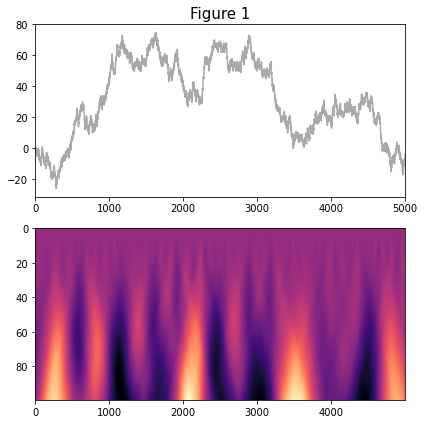

In [3]:
windows = np.linspace(10, 1000, 100)  # 100 windows, equally spaced from width 10 to 1000
kernel = kernel_functions.power_cusp  # a symmetric power-law type cusp
k_args = [3.]  # arguments for the kernel; in this case, it's the parameter $\theta = 3$.
reflection = 2  # reflect the kernel over the horizontal axis

dst, largest_kernel = shocklets.cusplet(
    x,
    windows,
    kernel_func=kernel,
    kernel_args=k_args,
    reflection=reflection
)

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
ax0, ax1 = axes
ax0.plot(x, 'darkgray')
ax0.set_xlim(0, len(x))
im = ax1.imshow(
    dst,
    aspect='auto',
    cmap=plt.cm.magma,
)

ax0.set_title('Figure 1', fontsize=15);
plt.tight_layout()

Lighter colors indicate large positive values while darker colors indicate large negative values. We see that the immediate output of the DST captures pieces of the time series that sort of "look" like the kernel, which in this case is an upside-down spike-y kind of thing (`shocklets.power_cusp` reflected over the horizontal axis).

From Figure 1 we can also see that the DST captures this behavior over all timescales. There are similar spikes in DST intensity for the small-ish peak near $n = 250$ as for the much larger ones that peaks near $n = 2000$ and $n = 3500$.

### Thresholding procedures

Now we can post-process. Let's find out in what actual windows of time $x_n$ 
had this sort of cusp-y behavior.

Text(0.5, 1.0, 'Figure 2')

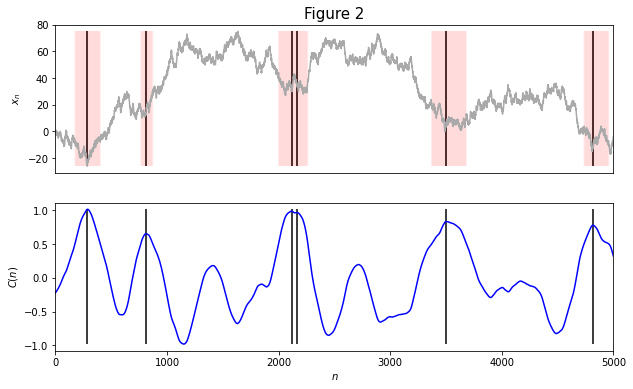

In [4]:
# extrema are the estimated extrema of the hypothesized underlying dynamics
# indicator is the cusplet indicator function, plotted below in a blue curve
# geval are indices of the cusplet indicator function where it exceeds geval
# b is a sensitivity parameter; higher b is less sensitive. 
extrema, indicator, gepoints = shocklets.classify_cusps( dst, b=0.5, geval=0.5 )
# now we can get and plot contiguous windows of cusp-y behavior
# these are created from the gepoints 
windows = shocklets.make_components(gepoints)

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
ax, ax2 = axes

ax.plot(x, 'darkgray')
ax.vlines(extrema, min(x), max(x))
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlim(0, len(x))

# annotate the windows
for window in windows:
    ax.vlines(window, min(x), max(x), alpha=0.01, color='r')

ax2.plot(indicator, 'b-')
ax2.vlines(extrema, min(indicator), max(indicator))
ax2.set_xlim(0, len(x))

ax.set_ylabel('$x_n$')
ax2.set_xlabel('$n$')
ax2.set_ylabel('$C(n)$')

ax.set_title('Figure 2', fontsize=15)

We'll work from the bottom up.
The blue curve in the bottom panel displays the cusp indicator function,
which (usually, unless you specified any custom weightings of the discrete 
shocklet transform) is roughly equivalent to `shocklets.zero_norm( np.sum(cc, axis=0) )`.
The vertical bars denote relative maxima $C^*$ of the cusp indicator function 
that satisfy the additional condition
$$
C^* \geq \mu_C + b \sigma_C,
$$
where $\mu_C$ and $\sigma_C$ are the mean and standard deviation of the cusp 
indicator function and $b$ is a tunable parameter that adjusts the sensitivity 
of the thresholding.
The top window again displays the $C^*$ in vertical bars and windows where the 
cusp indicator function exceeds some other threshold $b'$.